Name：
- 渗碳浓度计算

说明：
- import DeepXDE
- 边界条件：Dirichlet

---

In [1]:
# Libraries
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from deepxde.backend import tf  
import deepxde as dde
import numpy as np
import math
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Constants
LENGTH_OF_DOMAIN = 12
TIME = 2
INITIAL_CONC = 0
c_bar = 1.18074 # y(0,t)=10
q = 0.8824 # 合金元素影响因子
R = 8.314 # 气体常数
T = 1203 # 绝对温度（K）
D = 47 * q * math.exp(-1.6) * math.exp(-((154900-27630)/(R*T)))


In [3]:
# Domain Definition
LineDomain = dde.geometry.Interval(0, LENGTH_OF_DOMAIN)
TimeDomain = dde.geometry.TimeDomain(0, TIME)
CombinedDomain = dde.geometry.GeometryXTime(LineDomain, TimeDomain)

In [4]:
# Boundary Condition
def l_boundary(X, on_boundary):
  return on_boundary and np.isclose(X[0], 0)

l_bc = dde.icbc.DirichletBC(CombinedDomain, lambda X : c_bar, l_boundary)
initial_bc = dde.icbc.IC(CombinedDomain, lambda X : INITIAL_CONC, lambda _, on_initial : on_initial)

In [6]:
# PDE definition
def pde(X, u):
  du_dt = dde.grad.jacobian(u, X, i = 0, j = 1)
  ddu_dxx = dde.grad.hessian(u, X, i = 0, j = 0)
  return du_dt - (2*u + 2) * (ddu_dxx)

In [7]:
# PDE module
module = dde.data.TimePDE(
    CombinedDomain,
    pde,
    [l_bc, initial_bc],
    num_domain = 5000,
    num_boundary = 1200,
    num_initial = 1200,
    num_test = 5000,
)

In [8]:
# Defining and Compiling Model
net = dde.nn.FNN([2] + [100] * 2 + [1], "tanh", "Glorot normal")
model = dde.Model(module, net)
model.compile("adam", lr = 0.0001)

Compiling model...
'compile' took 0.171775 s



Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.02e-03, 1.26e+00, 2.11e+00]    [6.48e-03, 1.26e+00, 2.11e+00]    []  


1000      [1.01e-02, 1.56e-02, 4.84e-02]    [6.98e-03, 1.56e-02, 4.84e-02]    []  
2000      [6.15e-03, 1.72e-02, 3.87e-02]    [4.21e-03, 1.72e-02, 3.87e-02]    []  
3000      [3.90e-03, 1.36e-02, 3.31e-02]    [2.11e-03, 1.36e-02, 3.31e-02]    []  
4000      [2.24e-03, 1.25e-02, 2.56e-02]    [1.01e-03, 1.25e-02, 2.56e-02]    []  
5000      [1.37e-03, 1.20e-02, 1.94e-02]    [6.34e-04, 1.20e-02, 1.94e-02]    []  
6000      [1.21e-03, 9.63e-03, 1.61e-02]    [9.56e-04, 9.63e-03, 1.61e-02]    []  
7000      [1.24e-03, 6.99e-03, 1.27e-02]    [1.14e-03, 6.99e-03, 1.27e-02]    []  
8000      [1.02e-03, 5.56e-03, 9.38e-03]    [8.61e-04, 5.56e-03, 9.38e-03]    []  
9000      [8.96e-04, 4.49e-03, 7.05e-03]    [8.93e-04, 4.49e-03, 7.05e-03]    []  
10000     [5.88e-04, 3.98e-03, 5.33e-03]    [5.92e-04, 3.98e-03, 5.33e-03]    []  
11000     [4.76e-04, 3.50e-03, 4.35e-03]    [4.56e-04, 3.50e-03, 4.35e-03]    []  
12000     [4.25e-04, 3.14e-03, 3.73e-03]    [3.21e-04, 3.14e-03, 3.73e-03]    []  
1300

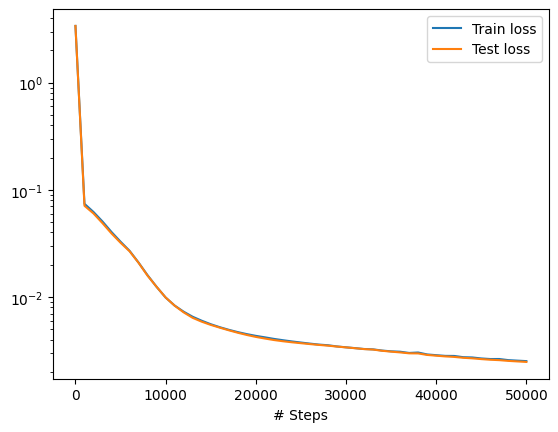

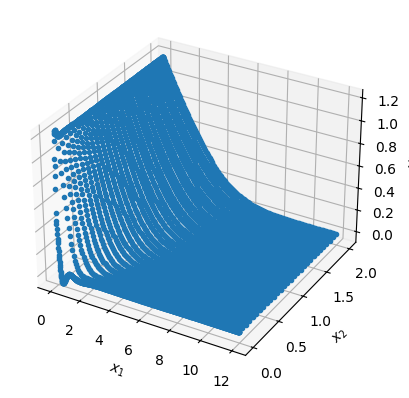

In [9]:
# Training Model
LossHistory, TrainState = model.train(iterations = 50000)
dde.saveplot(LossHistory, TrainState, issave = True, isplot = True)

### Finding PINN Solution

In [10]:
# Finding PINN Solution
ux = np.linspace(0, int(LENGTH_OF_DOMAIN), (int(LENGTH_OF_DOMAIN) * 30) + 1, dtype = "float")
ut = np.linspace(0, TIME, (TIME * 20) + 1, dtype = "float")
x, t = np.meshgrid(ux, ut)
X = np.array([x.flatten(), t.flatten()]).T

predicted_c = model.predict(X)
model_X_pinn = np.insert(X, [1], predicted_c.reshape((-1, 1)), axis = 1)